# Run the model

You must run this notebook only if the notebook [`01-prepare-data.ipynb`](./01-prepare-data.ipynb) has been ran.
We rely on the existence of the pre-processed dataset files to run the model.

First, we load the dataset from the CSV

In [20]:
import pandas as pd

data = pd.read_csv('data/reduced_dataset.csv')
print(data.head())

   Seating Capacity  Average Meal Price  Weekend Reservations  \
0                38               73.98                    13   
1                76               28.11                    48   
2                48               48.29                    27   
3                34               51.55                     9   
4                88               75.98                    37   

   Weekday Reservations     Revenue  Marketing&Followers  Location_Downtown  \
0                     4   638945.52            -0.870544              False   
1                     6   490207.83             0.712762               True   
2                    14   541368.62            -0.122085              False   
3                    17   404556.80            -1.591078              False   
4                    26  1491046.35             0.314123               True   

   Location_Rural  Location_Suburban  Cuisine_American  Cuisine_French  \
0            True              False             False      

After loading the data, we need to perform some immediate pre-processing. We cannot (in a simple way) load the already scaled values from the dataset, as we'll not be able to descale them back (in a simple way), so let's scale the columns right here.

We have the boolean and integer values in our dataset, need to convert everything to a consistent data type.

In [21]:
data = data.astype(float)
print(data.head())

   Seating Capacity  Average Meal Price  Weekend Reservations  \
0              38.0               73.98                  13.0   
1              76.0               28.11                  48.0   
2              48.0               48.29                  27.0   
3              34.0               51.55                   9.0   
4              88.0               75.98                  37.0   

   Weekday Reservations     Revenue  Marketing&Followers  Location_Downtown  \
0                   4.0   638945.52            -0.870544                0.0   
1                   6.0   490207.83             0.712762                1.0   
2                  14.0   541368.62            -0.122085                0.0   
3                  17.0   404556.80            -1.591078                0.0   
4                  26.0  1491046.35             0.314123                1.0   

   Location_Rural  Location_Suburban  Cuisine_American  Cuisine_French  \
0             1.0                0.0               0.0      

Now we rescale the inputs, but there exist a catch.
To properly calculate the absolute error, we need original, unscaled values of the output.

But we split the dataset to training and testing sections at random.

These two processes - rescaling and train/test splitting interfere with each other.
So, we will use the simplest good enough approach: we rescale everything and will perform all operations on scaled data.

Only when there's a need to calculate the errors, we will de-scale both the predicted outputs and test outputs using the same scaler as we used for scaling.
This is not exactly the same as using the original untouched data due to rounding errors, but it's good enough to calculate the errors.

If we want to actually *use* the model for actual predictions based on user-submitted values, we'll need to keep the scaling parameters together with all the model parameters, because we'll need to scale the user-provided input and then de-scale the predicted output before returning to the user.

In [22]:
from sklearn.preprocessing import StandardScaler
# this will be kept in memory and re-used later to de-normalize the outputs
scaler = StandardScaler()

# list of columns ONLY for the REDUCED dataset
columns_to_normalize = ['Seating Capacity', 'Average Meal Price', 'Weekend Reservations', 'Weekday Reservations']
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
# print(data.head())

revenue_scaler = StandardScaler()
scaled_revenues = revenue_scaler.fit_transform(data['Revenue'].values.reshape(-1, 1))
#scaled_revenues

data['Revenue'] = scaled_revenues


OK now let's split the dataset to training and testing 80:20

In [23]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


After splitting the dataset, we need to split them further to inputs and outputs. Here we immediately translate Pandas data frames to Numpy arrays using the `.values` property, as our `NeuralNet` object operates on Numpy arrays.

In [24]:
X_train = train_data.drop(columns=['Revenue']).values
y_train = train_data['Revenue'].values

X_test = test_data.drop(columns=['Revenue']).values
y_test = test_data['Revenue'].values

We are ready to run our homemade neural network

In [25]:
from NeuralNet import NeuralNet

First of all, let's try evaluating the network once with some arbitrarily chosen parameters.



input layer will contain the same number of inputs as input columns in the train dataset.

In [26]:
input_layer = X_train.shape[1]
input_layer

14

Let's pick three hidden layers with 21, 33 and 17 neurons, respectively.

In [27]:
layers = [input_layer, 21, 33, 17, 1]
layers

[14, 21, 33, 17, 1]

Our NeuralNet class has defaults for all the constructor arguments but let's specify by hand some of the most important ones for better visibility

In [28]:
nn = NeuralNet(layers=layers, epochs=100, learning_rate=0.1, momentum=0.6, activation_function_name='sigmoid', validation_split=0.2)

Now we fit it using the train data

In [29]:
nn.fit(X_train, y_train)

c:\projects\urv-nec-assignment-1\activation_functions.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch 1/100, Training Error: 8827.103466799916, Validation Error: 2177.9256557757026
Epoch 2/100, Training Error: 8568.030424285114, Validation Error: 2114.4272081636336
Epoch 3/100, Training Error: 8637.513615764177, Validation Error: 2134.585445500799
Epoch 4/100, Training Error: 8684.166615757267, Validation Error: 2137.6091811013735
Epoch 5/100, Training Error: 8658.358573207901, Validation Error: 2135.5933573676566
Epoch 6/100, Training Error: 8676.22567958823, Validation Error: 2142.648740435665
Epoch 7/100, Training Error: 8675.233062567104, Validation Error: 2140.632916701948
Epoch 8/100, Training Error: 8680.196147672747, Validation Error: 2141.6408285688067
Epoch 9/100, Training Error: 8664.314275334673, Validation Error: 2144.664564169381
Epoch 10/100, Training Error: 8651.410254059996, Validation Error: 2138.617092968231
Epoch 11/100, Training Error: 8652.402871081124, Validation Error: 2135.5933573676566
Epoch 12/100, Training Error: 8647.439785975475, Validation Error: 21

We are ready to calculate the mean errors. First, we get predictions on our test data.

In [30]:
y_pred = nn.predict(X_test)
print(y_pred)

[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]


As we mentioned before, this is not enough.
Now we need to de-scale the predicted values using the same scaler as the one used to scale data for training the model.
In addition to that, we need to de-scale the testing output values in the same way - getting the original values only for testing would lead to overly complicated data preparation procedure.

In [31]:
import numpy as np


In [ ]:
y_test_reshaped = y_test.reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)



In [33]:

# De-scale the predicted and test values
y_pred_descaled = revenue_scaler.inverse_transform(y_pred_reshaped)
y_test_descaled = revenue_scaler.inverse_transform(y_test_reshaped)

print(y_pred_descaled)
print(y_test_descaled)

[[656070.56335086]
 [656070.56335086]
 [656070.56335086]
 ...
 [923468.32154937]
 [923468.32154937]
 [923468.32154937]]
[[ 475928.6 ]
 [ 300655.99]
 [ 457425.31]
 ...
 [ 828629.6 ]
 [1164015.35]
 [ 951205.5 ]]


In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate the mean squared error
mse = mean_squared_error(y_test_descaled, y_pred_descaled)

# Calculate the mean absolute error
mae = mean_absolute_error(y_test_descaled, y_pred_descaled)

# Calculate the mean absolute percentage error
mape = np.mean(np.abs((y_test_descaled - y_pred_descaled) / y_test_descaled)) * 100

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}%")

Mean Squared Error: 66660909975.77586
Mean Absolute Error: 230255.0010539756
Mean Absolute Percentage Error: 46.22782593376568%


It seems that our model has a horrible performance!

Let's plot the difference between the testing outputs and predicted outputs.

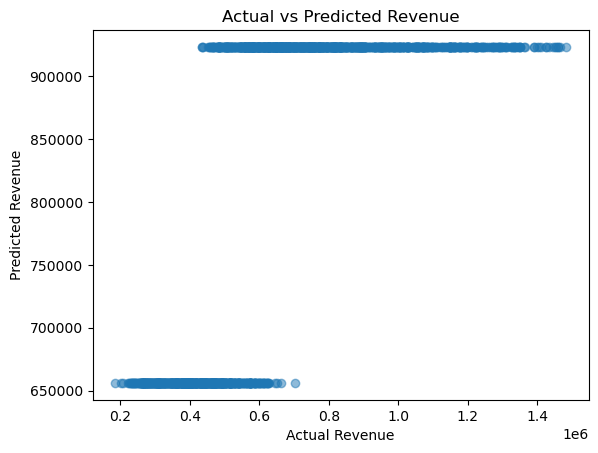

In [35]:
import matplotlib.pyplot as plt

plt.scatter(y_test_descaled, y_pred_descaled, alpha=0.5)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.show()

Such a scatterplot means that our model have a completely wrong, albeit consistent, behavior: on the samples which have some "smaller" revenue, less than some breakpoint around 0.61 M, it consistently returns the same small prediction. After that breakpoint, for all the samples it returns the same, a lot larger revenue.

This is essentially a classifier.

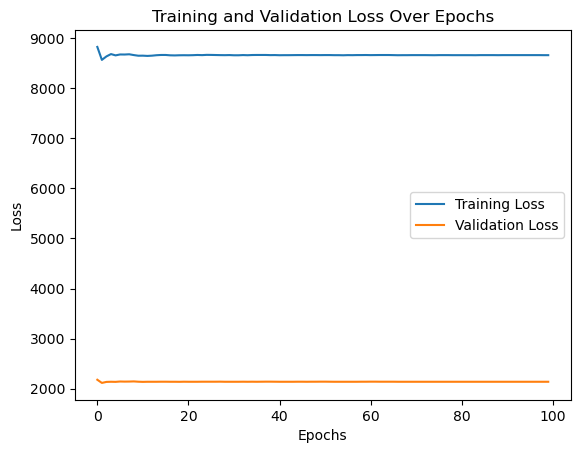

In [36]:
# Plot the evolution of the training and validation errors
train_loss, val_loss = nn.loss_epochs()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

## Intermediate Conclusions

Clearly, the model encoded in the NeuralNet.py doesn't actually learn. It can indicate either that we have a bug in the implementation of the backpropagation mechanism, or the dataset is fatally incompatible with the fully online backpropagation algorithm, and the errors must be processed from whole batches of training samples instead of the ones picked one-by-one.

## Hyperparameter comparison and selection

Nevertheless, let's perform a bit more comprehensive exploration of the neural network parameters space. Let's compact the above process into a single function so we can pass the neural network parameters and get the three error metrics in one go.

In [37]:
def evaluate(layers=layers, epochs=20, learning_rate=0.1, momentum=0.6, activation_function_name='sigmoid', validation_split=0.2, visualize=False):
    nn = NeuralNet(layers=layers, epochs=epochs, learning_rate=learning_rate, momentum=momentum, activation_function_name=activation_function_name, validation_split=validation_split, visualize=visualize)
    nn.fit(X_train, y_train)
    y_pred = nn.predict(X_test)
    y_pred_reshaped = y_pred.reshape(-1, 1)
    y_pred_descaled = revenue_scaler.inverse_transform(y_pred_reshaped)
    mse = mean_squared_error(y_test_descaled, y_pred_descaled)
    mae = mean_absolute_error(y_test_descaled, y_pred_descaled)
    mape = np.mean(np.abs((y_test_descaled - y_pred_descaled) / y_test_descaled)) * 100
    if visualize:
        plt.scatter(y_test_descaled, y_pred_descaled, alpha=0.5)
        plt.xlabel('Actual Revenue')
        plt.ylabel('Predicted Revenue')
        plt.title('Actual vs Predicted Revenue')
        plt.show()
        train_loss, val_loss = nn.loss_epochs()
        plt.plot(train_loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.legend()
        plt.show()
    return mse, mae, mape

Note that this function is a closure: it depends on the variables `X_train`, `y_train`, `X_test`, `revenue_scaler` and `y_test_descaled` in the environment!

This function contains an additional parameter `visualize` which, if set, enables plotting the scatterplot and training loss plot. It allows us to call this function a single time with better visualization.

The neural network which we are using is obviously broken beyond repair so there's no need to run it on the large amount of training epochs, so the default of 20 will be enough, but it is still configurable for individual launches.

The rationale behind choosing the variants is as follows.

1. Minimum recommeded learning rate seems to be 0.01 so let's check it. Next we check 0.15 as a "reasonable" value and then 0.5 as "slightly unreasonable"
2. Chose only two variants of momentum to reduce the search space. The logic is the same: 0.1 is a "reasonable" value and 0.5 is "more or less high".
3. Only two activation functions were used, both nonlinear, again, to reduce the search space but still use the "realistic" functions, from the real world.
4. Network configuration 14, 14, 14 is a "straightforward" one, we have 14 inputs and it just propagates them through three hidden layers.
5. Network configuration 5, 7 is an attempt to use just two hidden layers while aggressively reducing the amount of inputs
6. Network configuration 14, 7, 3 is a variant of the previous configuration, which also reduces the amount of inputs gradually, but through three hidden layers.

Network layer configurations has been chosen by guesswork strictly.

In [38]:
import pandas as pd

# Define the parameters to test
learning_rates = [0.01, 0.15, 0.5]
momentums = [0.1, 0.5]
activation_functions = ['tanh', 'sigmoid']
layer_variants = [
    [input_layer, 14, 14, 14, 1],
    [input_layer, 5, 7, 1],
    [input_layer, 14, 7, 3, 1]
]

# Initialize a list to store the results
results = []

# Iterate over all combinations of parameters
for lr in learning_rates:
    for momentum in momentums:
        for activation_function in activation_functions:
            for layers in layer_variants:
                print(f"Evaluating model with layers: {layers}, learning rate: {lr}, momentum: {momentum}, activation function: {activation_function}")
                mse, mae, mape = evaluate(layers=layers, learning_rate=lr, momentum=momentum, activation_function_name=activation_function)
                results.append({
                    'Layers': layers,
                    'Epochs': 20,
                    'Learning Rate': lr,
                    'Momentum': momentum,
                    'Activation Function': activation_function,
                    'MSE': mse,
                    'MAE': mae,
                    'MAPE': mape
                })
                print(f"Results: MSE: {mse}, MAE: {mae}, MAPE: {mape}%")

# Convert the results to a DataFrame for pretty-printing
results_df = pd.DataFrame(results)
print(results_df)

Evaluating model with layers: [14, 14, 14, 14, 1], learning rate: 0.01, momentum: 0.1, activation function: tanh
Results: MSE: 52596333734.57542, MAE: 177267.36891122858, MAPE: 25.44887145749476%
Evaluating model with layers: [14, 5, 7, 1], learning rate: 0.01, momentum: 0.1, activation function: tanh
Results: MSE: 131512714669.02744, MAE: 320211.89649240114, MAPE: 69.41562856336641%
Evaluating model with layers: [14, 14, 7, 3, 1], learning rate: 0.01, momentum: 0.1, activation function: tanh
Results: MSE: 99573531184.28987, MAE: 241771.60433629056, MAPE: 32.143708697576905%
Evaluating model with layers: [14, 14, 14, 14, 1], learning rate: 0.01, momentum: 0.1, activation function: sigmoid


c:\projects\urv-nec-assignment-1\activation_functions.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Results: MSE: 66698458230.94883, MAE: 230255.00105397566, MAPE: 46.23497039425579%
Evaluating model with layers: [14, 5, 7, 1], learning rate: 0.01, momentum: 0.1, activation function: sigmoid


c:\projects\urv-nec-assignment-1\activation_functions.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Results: MSE: 65944595630.1402, MAE: 228682.18686718546, MAPE: 45.946410106376035%
Evaluating model with layers: [14, 14, 7, 3, 1], learning rate: 0.01, momentum: 0.1, activation function: sigmoid


c:\projects\urv-nec-assignment-1\activation_functions.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Results: MSE: 66767153022.50555, MAE: 230414.73687129852, MAPE: 46.26276294976255%
Evaluating model with layers: [14, 14, 14, 14, 1], learning rate: 0.01, momentum: 0.5, activation function: tanh
Results: MSE: 82529692759.92444, MAE: 222603.3903319049, MAPE: 30.205194997574036%
Evaluating model with layers: [14, 5, 7, 1], learning rate: 0.01, momentum: 0.5, activation function: tanh
Results: MSE: 102380645120.13844, MAE: 286091.7067713094, MAPE: 60.811022161102436%
Evaluating model with layers: [14, 14, 7, 3, 1], learning rate: 0.01, momentum: 0.5, activation function: tanh
Results: MSE: 70058297150.2112, MAE: 235717.98993827973, MAPE: 48.30361580302065%
Evaluating model with layers: [14, 14, 14, 14, 1], learning rate: 0.01, momentum: 0.5, activation function: sigmoid


c:\projects\urv-nec-assignment-1\activation_functions.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Results: MSE: 66864864790.86604, MAE: 230734.20850594432, MAPE: 46.311920619997984%
Evaluating model with layers: [14, 5, 7, 1], learning rate: 0.01, momentum: 0.5, activation function: sigmoid


c:\projects\urv-nec-assignment-1\activation_functions.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Results: MSE: 65944595630.1402, MAE: 228682.18686718546, MAPE: 45.946410106376035%
Evaluating model with layers: [14, 14, 7, 3, 1], learning rate: 0.01, momentum: 0.5, activation function: sigmoid


c:\projects\urv-nec-assignment-1\activation_functions.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Results: MSE: 66864864790.86604, MAE: 230734.20850594432, MAPE: 46.311920619997984%
Evaluating model with layers: [14, 14, 14, 14, 1], learning rate: 0.15, momentum: 0.1, activation function: tanh
Results: MSE: 35890695184.06736, MAE: 152946.48686695253, MAPE: 23.973530055071553%
Evaluating model with layers: [14, 5, 7, 1], learning rate: 0.15, momentum: 0.1, activation function: tanh
Results: MSE: 41308694988.80351, MAE: 162743.16592713547, MAPE: 26.78367386493457%
Evaluating model with layers: [14, 14, 7, 3, 1], learning rate: 0.15, momentum: 0.1, activation function: tanh
Results: MSE: 140316099681.4379, MAE: 285862.41562187957, MAPE: 37.250343348796164%
Evaluating model with layers: [14, 14, 14, 14, 1], learning rate: 0.15, momentum: 0.1, activation function: sigmoid


c:\projects\urv-nec-assignment-1\activation_functions.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Results: MSE: 66522907150.88616, MAE: 229935.52941932986, MAPE: 46.17214768902453%
Evaluating model with layers: [14, 5, 7, 1], learning rate: 0.15, momentum: 0.1, activation function: sigmoid


c:\projects\urv-nec-assignment-1\activation_functions.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Results: MSE: 65839482557.77698, MAE: 228522.45104986258, MAPE: 45.91185618785193%
Evaluating model with layers: [14, 14, 7, 3, 1], learning rate: 0.15, momentum: 0.1, activation function: sigmoid


c:\projects\urv-nec-assignment-1\activation_functions.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Results: MSE: 66864864790.86604, MAE: 230734.20850594432, MAPE: 46.311920619997984%
Evaluating model with layers: [14, 14, 14, 14, 1], learning rate: 0.15, momentum: 0.5, activation function: tanh
Results: MSE: 45885338221.926094, MAE: 165946.2815826557, MAPE: 24.423739994817012%
Evaluating model with layers: [14, 5, 7, 1], learning rate: 0.15, momentum: 0.5, activation function: tanh
Results: MSE: 141560317180.98282, MAE: 287061.19611277524, MAPE: 37.39066469856859%
Evaluating model with layers: [14, 14, 7, 3, 1], learning rate: 0.15, momentum: 0.5, activation function: tanh
Results: MSE: 86553675000.9317, MAE: 263312.6684747114, MAPE: 55.229895787812374%
Evaluating model with layers: [14, 14, 14, 14, 1], learning rate: 0.15, momentum: 0.5, activation function: sigmoid


c:\projects\urv-nec-assignment-1\activation_functions.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Results: MSE: 66767153022.50555, MAE: 230414.73687129852, MAPE: 46.26276294976255%
Evaluating model with layers: [14, 5, 7, 1], learning rate: 0.15, momentum: 0.5, activation function: sigmoid


c:\projects\urv-nec-assignment-1\activation_functions.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Results: MSE: 65864936268.5844, MAE: 228522.45104986258, MAPE: 45.916852510767335%
Evaluating model with layers: [14, 14, 7, 3, 1], learning rate: 0.15, momentum: 0.5, activation function: sigmoid


c:\projects\urv-nec-assignment-1\activation_functions.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Results: MSE: 66831088156.32934, MAE: 230574.4726886214, MAPE: 46.290626397516974%
Evaluating model with layers: [14, 14, 14, 14, 1], learning rate: 0.5, momentum: 0.1, activation function: tanh
Results: MSE: 36167115366.18107, MAE: 153463.3544563508, MAPE: 24.045283949788015%
Evaluating model with layers: [14, 5, 7, 1], learning rate: 0.5, momentum: 0.1, activation function: tanh
Results: MSE: 41703853622.956795, MAE: 163816.34541139472, MAPE: 26.779329478967707%
Evaluating model with layers: [14, 14, 7, 3, 1], learning rate: 0.5, momentum: 0.1, activation function: tanh
Results: MSE: 42538047510.058464, MAE: 165262.00414160325, MAPE: 25.687651255019063%
Evaluating model with layers: [14, 14, 14, 14, 1], learning rate: 0.5, momentum: 0.1, activation function: sigmoid


c:\projects\urv-nec-assignment-1\activation_functions.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Results: MSE: 66698458230.94883, MAE: 230255.00105397566, MAPE: 46.23497039425579%
Evaluating model with layers: [14, 5, 7, 1], learning rate: 0.5, momentum: 0.1, activation function: sigmoid


c:\projects\urv-nec-assignment-1\activation_functions.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Results: MSE: 65944595630.1402, MAE: 228682.18686718546, MAPE: 45.946410106376035%
Evaluating model with layers: [14, 14, 7, 3, 1], learning rate: 0.5, momentum: 0.1, activation function: sigmoid


c:\projects\urv-nec-assignment-1\activation_functions.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Results: MSE: 66820598276.45329, MAE: 230574.47268862143, MAPE: 46.28739145782841%
Evaluating model with layers: [14, 14, 14, 14, 1], learning rate: 0.5, momentum: 0.5, activation function: tanh
Results: MSE: 139721147983.92072, MAE: 285381.8363604573, MAPE: 37.20349270551413%
Evaluating model with layers: [14, 5, 7, 1], learning rate: 0.5, momentum: 0.5, activation function: tanh
Results: MSE: 41562175109.01025, MAE: 163551.4042779104, MAPE: 26.737716917440775%
Evaluating model with layers: [14, 14, 7, 3, 1], learning rate: 0.5, momentum: 0.5, activation function: tanh
Results: MSE: 140915441515.5759, MAE: 286437.25307754066, MAPE: 37.31722680008428%
Evaluating model with layers: [14, 14, 14, 14, 1], learning rate: 0.5, momentum: 0.5, activation function: sigmoid


c:\projects\urv-nec-assignment-1\activation_functions.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Results: MSE: 66705176490.1886, MAE: 230414.73687129852, MAPE: 46.25235509593525%
Evaluating model with layers: [14, 5, 7, 1], learning rate: 0.5, momentum: 0.5, activation function: sigmoid


c:\projects\urv-nec-assignment-1\activation_functions.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Results: MSE: 65864936268.5844, MAE: 228522.45104986258, MAPE: 45.916852510767335%
Evaluating model with layers: [14, 14, 7, 3, 1], learning rate: 0.5, momentum: 0.5, activation function: sigmoid


c:\projects\urv-nec-assignment-1\activation_functions.py:25: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Results: MSE: 66749273386.743614, MAE: 230414.7368712985, MAPE: 46.25895277485729%
                 Layers  Epochs  Learning Rate  Momentum Activation Function  \
0   [14, 14, 14, 14, 1]      20           0.01       0.1                tanh   
1         [14, 5, 7, 1]      20           0.01       0.1                tanh   
2     [14, 14, 7, 3, 1]      20           0.01       0.1                tanh   
3   [14, 14, 14, 14, 1]      20           0.01       0.1             sigmoid   
4         [14, 5, 7, 1]      20           0.01       0.1             sigmoid   
5     [14, 14, 7, 3, 1]      20           0.01       0.1             sigmoid   
6   [14, 14, 14, 14, 1]      20           0.01       0.5                tanh   
7         [14, 5, 7, 1]      20           0.01       0.5                tanh   
8     [14, 14, 7, 3, 1]      20           0.01       0.5                tanh   
9   [14, 14, 14, 14, 1]      20           0.01       0.5             sigmoid   
10        [14, 5, 7, 1]      20      

In the case the above output would be mangled or lost for some reason, here is the resulting table in Markdown:

| Index | Layers              | Epochs | Learning Rate | Momentum | Activation Function | MSE           | MAE            | MAPE       |
|-------|---------------------|--------|---------------|----------|---------------------|---------------|----------------|------------|
| 0     | [14, 14, 14, 14, 1] | 20     | 0.01          | 0.1      | tanh                | 5.259633e+10  | 177267.368911  | 25.448871  |
| 1     | [14, 5, 7, 1]       | 20     | 0.01          | 0.1      | tanh                | 1.315127e+11  | 320211.896492  | 69.415629  |
| 2     | [14, 14, 7, 3, 1]   | 20     | 0.01          | 0.1      | tanh                | 9.957353e+10  | 241771.604336  | 32.143709  |
| 3     | [14, 14, 14, 14, 1] | 20     | 0.01          | 0.1      | sigmoid             | 6.669846e+10  | 230255.001054  | 46.234970  |
| 4     | [14, 5, 7, 1]       | 20     | 0.01          | 0.1      | sigmoid             | 6.594460e+10  | 228682.186867  | 45.946410  |
| 5     | [14, 14, 7, 3, 1]   | 20     | 0.01          | 0.1      | sigmoid             | 6.676715e+10  | 230414.736871  | 46.262763  |
| 6     | [14, 14, 14, 14, 1] | 20     | 0.01          | 0.5      | tanh                | 8.252969e+10  | 222603.390332  | 30.205195  |
| 7     | [14, 5, 7, 1]       | 20     | 0.01          | 0.5      | tanh                | 1.023806e+11  | 286091.706771  | 60.811022  |
| 8     | [14, 14, 7, 3, 1]   | 20     | 0.01          | 0.5      | tanh                | 7.005830e+10  | 235717.989938  | 48.303616  |
| 9     | [14, 14, 14, 14, 1] | 20     | 0.01          | 0.5      | sigmoid             | 6.686486e+10  | 230734.208506  | 46.311921  |
| 10    | [14, 5, 7, 1]       | 20     | 0.01          | 0.5      | sigmoid             | 6.594460e+10  | 228682.186867  | 45.946410  |
| 11    | [14, 14, 7, 3, 1]   | 20     | 0.01          | 0.5      | sigmoid             | 6.686486e+10  | 230734.208506  | 46.311921  |
| 12    | [14, 14, 14, 14, 1] | 20     | 0.15          | 0.1      | tanh                | 3.589070e+10  | 152946.486867  | 23.973530  |
| 13    | [14, 5, 7, 1]       | 20     | 0.15          | 0.1      | tanh                | 4.130869e+10  | 162743.165927  | 26.783674  |
| 14    | [14, 14, 7, 3, 1]   | 20     | 0.15          | 0.1      | tanh                | 1.403161e+11  | 285862.415622  | 37.250343  |
| 15    | [14, 14, 14, 14, 1] | 20     | 0.15          | 0.1      | sigmoid             | 6.652291e+10  | 229935.529419  | 46.172148  |
| 16    | [14, 5, 7, 1]       | 20     | 0.15          | 0.1      | sigmoid             | 6.583948e+10  | 228522.451050  | 45.911856  |
| 17    | [14, 14, 7, 3, 1]   | 20     | 0.15          | 0.1      | sigmoid             | 6.686486e+10  | 230734.208506  | 46.311921  |
| 18    | [14, 14, 14, 14, 1] | 20     | 0.15          | 0.5      | tanh                | 4.588534e+10  | 165946.281583  | 24.423740  |
| 19    | [14, 5, 7, 1]       | 20     | 0.15          | 0.5      | tanh                | 1.415603e+11  | 287061.196113  | 37.390665  |
| 20    | [14, 14, 7, 3, 1]   | 20     | 0.15          | 0.5      | tanh                | 8.655368e+10  | 263312.668475  | 55.229896  |
| 21    | [14, 14, 14, 14, 1] | 20     | 0.15          | 0.5      | sigmoid             | 6.676715e+10  | 230414.736871  | 46.262763  |
| 22    | [14, 5, 7, 1]       | 20     | 0.15          | 0.5      | sigmoid             | 6.586494e+10  | 228522.451050  | 45.916853  |
| 23    | [14, 14, 7, 3, 1]   | 20     | 0.15          | 0.5      | sigmoid             | 6.683109e+10  | 230574.472689  | 46.290626  |
| 24    | [14, 14, 14, 14, 1] | 20     | 0.50          | 0.1      | tanh                | 3.616712e+10  | 153463.354456  | 24.045284  |
| 25    | [14, 5, 7, 1]       | 20     | 0.50          | 0.1      | tanh                | 4.170385e+10  | 163816.345411  | 26.779329  |
| 26    | [14, 14, 7, 3, 1]   | 20     | 0.50          | 0.1      | tanh                | 4.253805e+10  | 165262.004142  | 25.687651  |
| 27    | [14, 14, 14, 14, 1] | 20     | 0.50          | 0.1      | sigmoid             | 6.669846e+10  | 230255.001054  | 46.234970  |
| 28    | [14, 5, 7, 1]       | 20     | 0.50          | 0.1      | sigmoid             | 6.594460e+10  | 228682.186867  | 45.946410  |
| 29    | [14, 14, 7, 3, 1]   | 20     | 0.50          | 0.1      | sigmoid             | 6.682060e+10  | 230574.472689  | 46.287391  |
| 30    | [14, 14, 14, 14, 1] | 20     | 0.50          | 0.5      | tanh                | 1.397211e+11  | 285381.836360  | 37.203493  |
| 31    | [14, 5, 7, 1]       | 20     | 0.50          | 0.5      | tanh                | 4.156218e+10  | 163551.404278  | 26.737717  |
| 32    | [14, 14, 7, 3, 1]   | 20     | 0.50          | 0.5      | tanh                | 1.409154e+11  | 286437.253078  | 37.317227  |
| 33    | [14, 14, 14, 14, 1] | 20     | 0.50          | 0.5      | sigmoid             | 6.670518e+10  | 230414.736871  | 46.252355  |
| 34    | [14, 5, 7, 1]       | 20     | 0.50          | 0.5      | sigmoid             | 6.586494e+10  | 228522.451050  | 45.916853  |
| 35    | [14, 14, 7, 3, 1]   | 20     | 0.50          | 0.5      | sigmoid             | 6.674927e+10  | 230414.736871  | 46.258953  |

The same table, but sorted by the MAPE ascending is below. It seems that configuration 12 is at least better than all others.

Interestingly enough, it looks like the $tanh$ function produces better results, and the top 4 are all of the shape `[14, 14, 14, 14, 1]`

| **Index** | **Layers**          | **Epochs** | **Learning Rate** | **Momentum** | **Activation Function** | **MSE**      | **MAE**       | **MAPE**  |
| --------- | ------------------- | ---------- | ----------------- | ------------ | ----------------------- | ------------ | ------------- | --------- |
| 12        | [14, 14, 14, 14, 1] | 20         | 0.15              | 0.1          | tanh                    | 3.589070e+10 | 152946.486867 | 23.973530 |
| 24        | [14, 14, 14, 14, 1] | 20         | 0.50              | 0.1          | tanh                    | 3.616712e+10 | 153463.354456 | 24.045284 |
| 18        | [14, 14, 14, 14, 1] | 20         | 0.15              | 0.5          | tanh                    | 4.588534e+10 | 165946.281583 | 24.423740 |
| 0         | [14, 14, 14, 14, 1] | 20         | 0.01              | 0.1          | tanh                    | 5.259633e+10 | 177267.368911 | 25.448871 |
| 26        | [14, 14, 7, 3, 1]   | 20         | 0.50              | 0.1          | tanh                    | 4.253805e+10 | 165262.004142 | 25.687651 |
| 31        | [14, 5, 7, 1]       | 20         | 0.50              | 0.5          | tanh                    | 4.156218e+10 | 163551.404278 | 26.737717 |
| 25        | [14, 5, 7, 1]       | 20         | 0.50              | 0.1          | tanh                    | 4.170385e+10 | 163816.345411 | 26.779329 |
| 13        | [14, 5, 7, 1]       | 20         | 0.15              | 0.1          | tanh                    | 4.130869e+10 | 162743.165927 | 26.783674 |
| 6         | [14, 14, 14, 14, 1] | 20         | 0.01              | 0.5          | tanh                    | 8.252969e+10 | 222603.390332 | 30.205195 |
| 2         | [14, 14, 7, 3, 1]   | 20         | 0.01              | 0.1          | tanh                    | 9.957353e+10 | 241771.604336 | 32.143709 |
| 30        | [14, 14, 14, 14, 1] | 20         | 0.50              | 0.5          | tanh                    | 1.397211e+11 | 285381.836360 | 37.203493 |
| 14        | [14, 14, 7, 3, 1]   | 20         | 0.15              | 0.1          | tanh                    | 1.403161e+11 | 285862.415622 | 37.250343 |
| 32        | [14, 14, 7, 3, 1]   | 20         | 0.50              | 0.5          | tanh                    | 1.409154e+11 | 286437.253078 | 37.317227 |
| 19        | [14, 5, 7, 1]       | 20         | 0.15              | 0.5          | tanh                    | 1.415603e+11 | 287061.196113 | 37.390665 |
| 16        | [14, 5, 7, 1]       | 20         | 0.15              | 0.1          | sigmoid                 | 6.583948e+10 | 228522.451050 | 45.911856 |
| 22        | [14, 5, 7, 1]       | 20         | 0.15              | 0.5          | sigmoid                 | 6.586494e+10 | 228522.451050 | 45.916853 |
| 34        | [14, 5, 7, 1]       | 20         | 0.50              | 0.5          | sigmoid                 | 6.586494e+10 | 228522.451050 | 45.916853 |
| 4         | [14, 5, 7, 1]       | 20         | 0.01              | 0.1          | sigmoid                 | 6.594460e+10 | 228682.186867 | 45.946410 |
| 10        | [14, 5, 7, 1]       | 20         | 0.01              | 0.5          | sigmoid                 | 6.594460e+10 | 228682.186867 | 45.946410 |
| 28        | [14, 5, 7, 1]       | 20         | 0.50              | 0.1          | sigmoid                 | 6.594460e+10 | 228682.186867 | 45.946410 |
| 15        | [14, 14, 14, 14, 1] | 20         | 0.15              | 0.1          | sigmoid                 | 6.652291e+10 | 229935.529419 | 46.172148 |
| 3         | [14, 14, 14, 14, 1] | 20         | 0.01              | 0.1          | sigmoid                 | 6.669846e+10 | 230255.001054 | 46.234970 |
| 27        | [14, 14, 14, 14, 1] | 20         | 0.50              | 0.1          | sigmoid                 | 6.669846e+10 | 230255.001054 | 46.234970 |
| 33        | [14, 14, 14, 14, 1] | 20         | 0.50              | 0.5          | sigmoid                 | 6.670518e+10 | 230414.736871 | 46.252355 |
| 35        | [14, 14, 7, 3, 1]   | 20         | 0.50              | 0.5          | sigmoid                 | 6.674927e+10 | 230414.736871 | 46.258953 |
| 5         | [14, 14, 7, 3, 1]   | 20         | 0.01              | 0.1          | sigmoid                 | 6.676715e+10 | 230414.736871 | 46.262763 |
| 21        | [14, 14, 14, 14, 1] | 20         | 0.15              | 0.5          | sigmoid                 | 6.676715e+10 | 230414.736871 | 46.262763 |
| 29        | [14, 14, 7, 3, 1]   | 20         | 0.50              | 0.1          | sigmoid                 | 6.682060e+10 | 230574.472689 | 46.287391 |
| 23        | [14, 14, 7, 3, 1]   | 20         | 0.15              | 0.5          | sigmoid                 | 6.683109e+10 | 230574.472689 | 46.290626 |
| 9         | [14, 14, 14, 14, 1] | 20         | 0.01              | 0.5          | sigmoid                 | 6.686486e+10 | 230734.208506 | 46.311921 |
| 11        | [14, 14, 7, 3, 1]   | 20         | 0.01              | 0.5          | sigmoid                 | 6.686486e+10 | 230734.208506 | 46.311921 |
| 17        | [14, 14, 7, 3, 1]   | 20         | 0.15              | 0.1          | sigmoid                 | 6.686486e+10 | 230734.208506 | 46.311921 |
| 8         | [14, 14, 7, 3, 1]   | 20         | 0.01              | 0.5          | tanh                    | 7.005830e+10 | 235717.989938 | 48.303616 |
| 20        | [14, 14, 7, 3, 1]   | 20         | 0.15              | 0.5          | tanh                    | 8.655368e+10 | 263312.668475 | 55.229896 |
| 7         | [14, 5, 7, 1]       | 20         | 0.01              | 0.5          | tanh                    | 1.023806e+11 | 286091.706771 | 60.811022 |
| 1         | [14, 5, 7, 1]       | 20         | 0.01              | 0.1          | tanh                    | 1.315127e+11 | 320211.896492 | 69.415629 |

To compare the results, below is the full output for the configuration 12, with scatterplot and training error plots, and for the configuration 1, which is the worst performing in terms of MAPE. Epochs count is 50.

Epoch 1/50, Training Error: 10766.75378945936, Validation Error: 2637.894380649214
Epoch 2/50, Training Error: 10773.302400142466, Validation Error: 2639.543245454974
Epoch 3/50, Training Error: 10482.514460547487, Validation Error: 2579.4446939068657
Epoch 4/50, Training Error: 8881.641350539825, Validation Error: 2168.5668113229376
Epoch 5/50, Training Error: 9518.523158343309, Validation Error: 2330.1543020425875
Epoch 6/50, Training Error: 10773.286108679948, Validation Error: 2639.5391420456967
Epoch 7/50, Training Error: 9151.87080552398, Validation Error: 2236.730777190395
Epoch 8/50, Training Error: 10551.114562115019, Validation Error: 2597.3409632021467
Epoch 9/50, Training Error: 10741.421087265735, Validation Error: 2646.069570501679
Epoch 10/50, Training Error: 10732.408564774012, Validation Error: 2643.872194545432
Epoch 11/50, Training Error: 10773.16251836028, Validation Error: 2639.508029256472
Epoch 12/50, Training Error: 9533.023217107955, Validation Error: 2335.2224

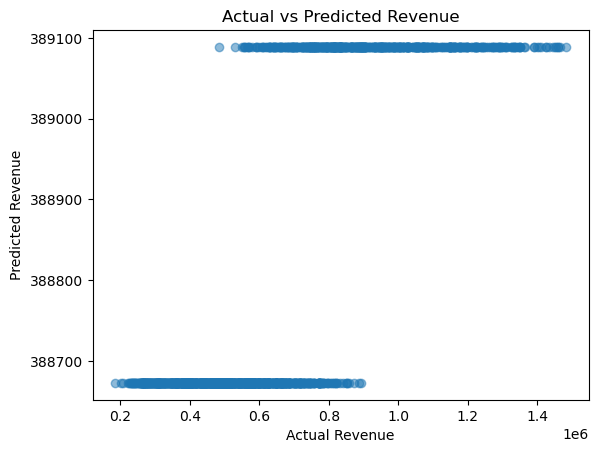

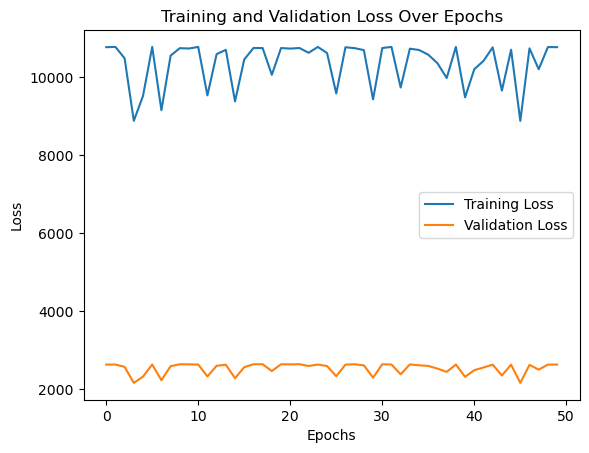

(141780991292.76736, 287271.27111144934, 37.41506259541686)

In [39]:
evaluate(layers=[input_layer, 14, 14, 14, 1], epochs=50, learning_rate=0.15, momentum=0.1, activation_function_name='tanh', visualize=True)

Epoch 1/50, Training Error: 8724.044826026058, Validation Error: 2156.957719541397
Epoch 2/50, Training Error: 10692.807078175916, Validation Error: 2660.361321372764
Epoch 3/50, Training Error: 9699.685017332175, Validation Error: 2396.5666413552426
Epoch 4/50, Training Error: 8522.71294499957, Validation Error: 2106.5517880685024
Epoch 5/50, Training Error: 10694.21608354448, Validation Error: 2660.7154400008117
Epoch 6/50, Training Error: 9689.96776525441, Validation Error: 2394.6297329403737
Epoch 7/50, Training Error: 8540.035208152483, Validation Error: 2109.135309199602
Epoch 8/50, Training Error: 8514.85545867424, Validation Error: 2104.364728770722
Epoch 9/50, Training Error: 9201.726696680667, Validation Error: 2282.2119621118786
Epoch 10/50, Training Error: 9041.869227248408, Validation Error: 2233.597226758455
Epoch 11/50, Training Error: 8738.909629204949, Validation Error: 2164.4063151344903
Epoch 12/50, Training Error: 8515.82048763242, Validation Error: 2105.25809423768

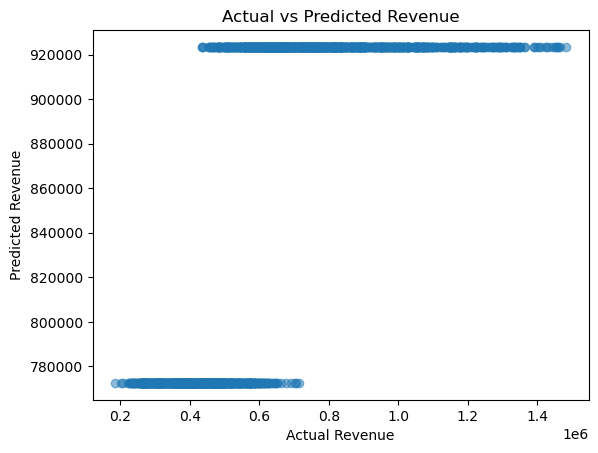

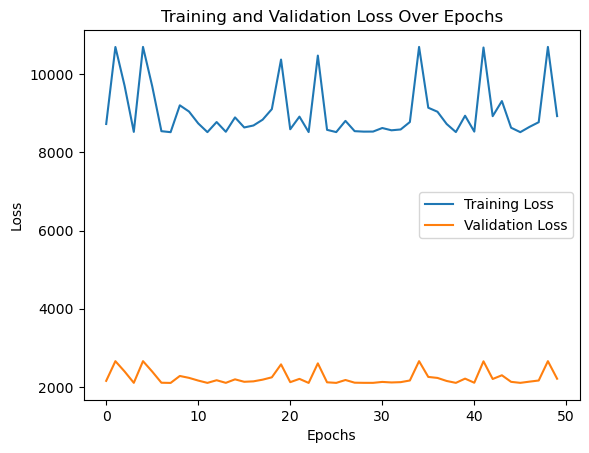

(91536040083.56285, 271336.653793159, 57.090866366965784)

In [40]:
evaluate(layers=[input_layer, 5, 7, 1], epochs=50, learning_rate=0.01, momentum=0.1, activation_function_name='tanh', visualize=True)

# Conclusion

Clearly, this model is inadequate.

Judging by its behavior, it's effectively a classifier, emitting either 0 or 1.
Why this happens is a topic of another investigation, most possibly it's because of a mistake in the encoding of the backpropagation calculations in the NeuralNet.py code.

As we see later in the [`03-compare-with.ipynb`](./03-compare-with.ipynb) notebook, Pytorch neural network is able to predict the revenue very well, so it's not the problem of the input data.

There's no value in checking the non-reduced dataset (the one which includes all the variables) until the neural network code will be fixed.

Despite that, this notebook can be used as is for any future evaluation of the NeuralNetwork.py, without any changes.
Potentially, after the code review and correction, this notebook will calculate to different results. This conclusion will be different then.